# Web-scraping: сбор данных из баз данных и интернет-источников


## Обработка таблиц внутри HTML с `BeautifulSoup` и `pandas`

*Алла Тамбовцева*

Импортируем библиотеки и функцию `BeautifulSoup` (понадобятся для примеров ниже):

* `requests` для отправки запроса и получения кода HTML веб-страницы;
* `bs4` для поиска тэгов в коде HTML;
* `pandas` для обработки полученной информации и приведения ее к табличному виду.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

Для игрушечного примера создадим строку с кодом HTML для маленькой таблицы с двумя строками и тремя столбцами:

In [2]:
# tr – table row (строка), 
# th – table header (ячейка с заголовком столбца), 
# td - table data (ячейка с данными)


table = """
<table>
        <tr><th></th><th>Значение</th></tr>
        <tr><th>Рейтинг (Кинопоиск)</th><td>7.9</td></tr>
        <tr><th>Рейтинг (Кино-Театр)</th><td>8.8</td></tr>
    </table>
"""

Посмотрим на то, как эта таблица выглядит. Для этого скопируем строку с кодом HTML без кавычек в ячейку Jupyter Notebook и изменим ее тип на *Markdown*, он позволит преобразовать код в таблицу и покажет ее на экране:

<table>
        <tr><th></th><th>Значение</th></tr>
        <tr><th>Рейтинг (Кинопоиск)</th><td>7.9</td></tr>
        <tr><th>Рейтинг (Кино-Театр)</th><td>8.8</td></tr>
    </table>

Сконвертируем строку `table` (тип *string*) в объект `BeautifulSoup` для удобства поиска по тэгам:

In [3]:
tab = BeautifulSoup(table)
tab

<html><body><table>
<tr><th></th><th>Значение</th></tr>
<tr><th>Рейтинг (Кинопоиск)</th><td>7.9</td></tr>
<tr><th>Рейтинг (Кино-Театр)</th><td>8.8</td></tr>
</table>
</body></html>

Найдем все ячейки с данными по тэгу `<td>` и извлечем из кода HTML текст:

In [4]:
tds = tab.find_all("td")
values = [v.text for v in tds]
values

['7.9', '8.8']

Теперь, чтобы получить полноценную таблицу, нужно разбить список на части (две строки) и преобразовать в датафрейм. Эту задачу можно решать по-разному. Мы преобразуем список в массив и разобьем его на два массива одинаковой длины через функцию `split()` из библиотеки `numpy`:

In [5]:
import numpy as np

In [6]:
dat = pd.DataFrame(np.split(np.array(values), 2)) # 2 массива внутри
dat

,0
0,7.9
1,8.8


Теперь осталось извлечь заголовки с названиями рейтингов. Для этого придется найти все элементы с тэгом `<th>` и выбрать нужные:

In [7]:
tab.find_all("th")[2:]

[<th>Рейтинг (Кинопоиск)</th>, <th>Рейтинг (Кино-Театр)</th>]

Вновь извлекаем текст и записываем названия рейтингов как названия строк в датафрейме:

In [8]:
names = [n.text for n in tab.find_all("th")[2:]]
dat.index = names
dat

,0
Рейтинг (Кинопоиск),7.9
Рейтинг (Кино-Театр),8.8


Итак, мы посмотрели, как можно с помощью BeautifulSoup, Numpy и Pandas справиться с парсингом фрагмента HTML-кода, содержащим таблицу. На самом деле, можно было поступить гораздо проще – задействовать специальную функцию `read_html()` из библиотеки `pandas`. Вернемся к строке `table` с кодом HTML (преобразовывать ее в объект BeautifulSoup не нужно!) и воспользуемся этой функцией:

In [9]:
# по умолчанию считывает все таблицы и возвращает все таблицы из HTML в виде списка
# здесь одна – извлекаем элемент с индексом 0

pd.read_html(table)[0] 

,Unnamed: 0,Значение
0,Рейтинг (Кинопоиск),7.9
1,Рейтинг (Кино-Театр),8.8


Выглядит симпатично и просто.

Теперь перейдем к более продвинутой задаче. Зайдем на сайт Левада-Центра и найдем на [странице](https://www.levada.ru/indikatory/) с индикаторами одобрения органов власти первую таблицу с данными (под первым графиком, имеет индекс 0):

In [10]:
page = requests.get("https://www.levada.ru/indikatory/")
soup = BeautifulSoup(page.text)
tab0 = soup.find_all("table", {"class" : "datatable"})[0]

Преобразуем объект `tab0` в строку, так как функция `read_html()` умеет работать только с обычными строками или файлами, а не с объектами `BeautifulSoup`, и создаем датафрейм на основе кода HTML, указав, что первая строка таблицы содержит заголовки столбцов (`header`):

In [11]:
df = pd.read_html(str(tab0), header = 0)[0]
df

,08.1999,09.1999,10.1999,11.1999,12.1999,01.2000,02.2000,03.2000,04.2000,05.2000,...,03.2022,04.2022,05.2022,06.2022,07.2022,08.2022,09.2022,10.2022,11.2022,12.2022
0,31,53,65,80,79,84,75,70,77,72,...,83,82,83,83,83,83,77,79,79,81
1,33,27,20,12,13,10,17,21,15,17,...,15,17,15,16,15,15,21,19,18,17
2,37,20,15,8,8,7,8,9,8,11,...,2,1,2,1,2,2,2,2,3,2


Ура! Одной строчкой кода мы получили красивую таблицу вместо «сырого» фрагмента HTML. Давайте транспонируем полученный датафрейм, чтобы получить более привычный вариант таблицы (и удобный для визуализации, если нас интересует динамика процента одобряющий и неодобряющих):

In [12]:
df = df.transpose() 
df

,0,1,2
08.1999,31,33,37
09.1999,53,27,20
10.1999,65,20,15
11.1999,80,12,8
12.1999,79,13,8
...,...,...,...
08.2022,83,15,2
09.2022,77,21,2
10.2022,79,19,2
11.2022,79,18,3


Обработаем этот датафрейм:

* добавим названия столбцов;
* извлечем даты из названией строк (атрибут `index`) и сохраним их в отдельный столбец;
* в качестве названий строк добавим набор целых чисел от 0 до 279;
* переставим столбцы местами – выбирем их в нужном порядке и перезаписываем `df`;

In [13]:
df.columns = ["yes", "no", "no answer"]
df["date"] = df.index
df.index = range(0, 279) 
df = df[["date", "yes", "no", "no answer"]]
df

,date,yes,no,no answer
0,08.1999,31,33,37
1,09.1999,53,27,20
2,10.1999,65,20,15
3,11.1999,80,12,8
4,12.1999,79,13,8
...,...,...,...,...
274,08.2022,83,15,2
275,09.2022,77,21,2
276,10.2022,79,19,2
277,11.2022,79,18,3


Проверим типы столбцов:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
date         279 non-null object
yes          279 non-null int64
no           279 non-null int64
no answer    279 non-null int64
dtypes: int64(3), object(1)
memory usage: 8.8+ KB


Все отлично, числовые данные сохранены как целые числа, но дату стоит перевести в специальный формат `datetime`, иначе сортировать данные и визуализировать их будет сложно – текст с датами не будет упорядочиваться хронологически. Воспользуемся функцией `to_datetime()` и укажем, в каком формате у нас сохранены даты (про форматы и соответствующие аббревиатуры можно почитать [здесь](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)):

In [15]:
# format: в каком формате даты в строке
# %m - шаблон для месяцев в числовом виде
# %Y – шаблон для лет в числовом виде (Y - 4 цифры, y – 2 цифры)

df["date"] = pd.to_datetime(df["date"], format = "%m.%Y")

Тип столбца изменился:

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 4 columns):
date         279 non-null datetime64[ns]
yes          279 non-null int64
no           279 non-null int64
no answer    279 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 8.8 KB


И для определенности к каждой дате (а у нас был только месяц и год) приписалось число – первый день месяца:

In [17]:
df.head()

,date,yes,no,no answer
0,1999-08-01,31,33,37
1,1999-09-01,53,27,20
2,1999-10-01,65,20,15
3,1999-11-01,80,12,8
4,1999-12-01,79,13,8


Проверим, что при визуализации динамики все будет в порядке, хронология не будет нарушена. Построим маленький базовый график с помощью функции `plot()`, без особых настроек, для примера. Импортируем модуль `pyplot`:

In [18]:
from matplotlib import pyplot as plt

Давайте в одной координатной плоскости построим сразу два графика – покажем динамику для процента одобряющих и неодобряющих деятельность Владимира Путина:

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


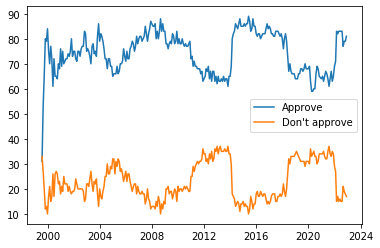

In [19]:
# label – чтобы назвать каждый график и отразить это в легенде

plt.plot(df["date"], df["yes"], label = "Approve")
plt.plot(df["date"], df["no"], label = "Don't approve")
plt.legend()

Отлично! График готов, похож на аналогичный график на сайте Левада-Центра. Конечно, размер и масштаб у этого графика не очень подходящие, но это всегда можно исправить (см. материалы по визуализации [здесь](http://math-info.hse.ru/s22/d)).